In [1]:
import sys
import math
sys.path.insert(0, "..")

import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functional, losses
from edunets.tensor import Tensor

## Preliminaries
### Making sure the basic convolution operation (or cross-correlation) works

Before anything else, let's make sure edunet's can perform simple matrix convolutions.

Let's start by making sure the kernel I = [[0, 0, 0], [0, 1, 0], [0, 0, 0]], is the 'identity' kernel for convolutions

In [2]:
torch_input = torch.tensor(np.array([[1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.]])[None, None], requires_grad=True)
edu_input = Tensor(np.array([[1., 2., 3., 4.], [1.,2.,3.,4.], [1.,2.,3.,4.]])[None, None], requires_grad=True)
torch_kernel = torch.tensor(np.array([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]])[None, None])
edu_kernel = Tensor(np.array([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]])[None, None])

print(f"torch input (shape={torch_input.shape}):")
print(torch_input)
print("edunets input:")
print(edu_input)
print(f"torch kernel (shape={torch_kernel.shape}):")
print(torch_kernel)
print("edunets kernel:")
print(edu_kernel)

torch input (shape=torch.Size([1, 1, 3, 4])):
tensor([[[[1., 2., 3., 4.],
          [1., 2., 3., 4.],
          [1., 2., 3., 4.]]]], dtype=torch.float64, requires_grad=True)
edunets input:
tensor([[[[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]]]], requires_grad=True)
torch kernel (shape=torch.Size([1, 1, 3, 3])):
tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]], dtype=torch.float64)
edunets kernel:
tensor([[[[0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.]]]])


In order to test if the kernel is the identity for convolutions, we need to pad the input first:

In [3]:
torch_padded_input = F.pad(torch_input, (1, 1, 1, 1))
print(torch_input.shape, "->", torch_padded_input.shape)
F.conv2d(torch_padded_input, torch_kernel)

torch.Size([1, 1, 3, 4]) -> torch.Size([1, 1, 5, 6])


tensor([[[[1., 2., 3., 4.],
          [1., 2., 3., 4.],
          [1., 2., 3., 4.]]]], dtype=torch.float64,
       grad_fn=<ThnnConv2DBackward>)

Or we can use the padding="same" directive:

In [4]:
# Convolution using PyTorch
out = F.conv2d(torch_input, torch_kernel, padding="same")

print(out)

out.backward(torch.ones(out.shape))

print("Gradient of input:")
print(torch_input.grad)

tensor([[[[1., 2., 3., 4.],
          [1., 2., 3., 4.],
          [1., 2., 3., 4.]]]], dtype=torch.float64,
       grad_fn=<ThnnConv2DBackward>)
Gradient of input:
tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]], dtype=torch.float64)


In [5]:
# Convolution using Edunets
out = functional.conv(edu_input, edu_kernel, padding="same")

print(out)

out.backward(Tensor.ones(*out.shape))

print("Gradient of input:")
print(edu_input.grad)

tensor([[[[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]]]], dtype=float32)
Gradient of input:
[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]]


It works! Our kernel acts like the identity for convolutions in both frameworks.

### Now let's add channels and batches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


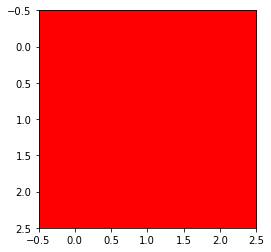

In [6]:
# An image is encoded as channels x height x width
# Here is a 3x3 red image:
dummy_red_img = np.array([
    [
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]
    ],
    [
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]
    ],
    [
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]
    ]
])

plt.imshow(dummy_red_img.transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


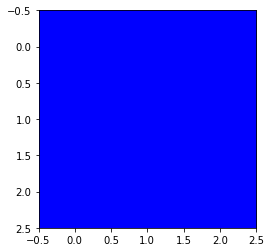

In [7]:
dummy_blue_img = np.array([
    [
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]
    ],
    [
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]
    ],
    [
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]
    ]
])

plt.imshow(dummy_blue_img.transpose((1,2,0)))

In [8]:
torch_input = torch.tensor([dummy_red_img, dummy_blue_img], requires_grad=True)
torch_input

tensor([[[[255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],

         [[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,   0.]],

         [[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,   0.]]],


        [[[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,   0.]],

         [[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,   0.]],

         [[255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]]]], dtype=torch.float64, requires_grad=True)

In [9]:
torch_kernel = torch.ones((3,3), dtype=torch.float64).repeat(1, 3, 1, 1)
print("Shape of the kernel:", torch_kernel.shape)
torch_kernel

Shape of the kernel: torch.Size([1, 3, 3, 3])


tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], dtype=torch.float64)

In [10]:
F.conv2d(torch_input, torch_kernel) # note: 2295 = 255 * 9

tensor([[[[2295.]]],


        [[[2295.]]]], dtype=torch.float64, grad_fn=<ThnnConv2DBackward>)

In [11]:
# Now in edunets
edu_input = Tensor(torch_input.detach().numpy())
edu_kernel = Tensor(torch_kernel.detach().numpy())
functional.conv(edu_input, edu_kernel)

tensor([[[[2295.]]],


       [[[2295.]]]], dtype=float32)

## Building Conv2d in edunets

In [26]:
class Conv2d:
    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride=1, padding=0, bias=True):
        # Paramaters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.padding = padding

        # Initiating Kernel
        self.real_kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        stdv = 1./np.sqrt(math.prod(self.real_kernel_size))
        self.kernel = Tensor.uniform(*self.real_kernel_size, low=-stdv, high=stdv, requires_grad=True)

        # Initiating Bias
        if bias is True:
            stdv = 1./np.sqrt(out_channels if isinstance(out_channels, int) else math.prod(out_channels))
            self.bias = Tensor.uniform(1, out_channels, 1, 1, low=-stdv, high=stdv, requires_grad=True)
        else:
            self.bias = None

    def __call__(self, x):
        batch, in_channels, width, height = x.shape

        # Reshaping kernel and bias to match the channels and depth
        self.kernel = self.kernel.repeat((batch, in_channels, 1, 1))

        convolution = functional.conv(x, self.kernel, stride=self.stride, padding=self.padding)
        print(convolution.shape)
        convolution = convolution.repeat((1, self.out_channels, 1, 1))
        
        if self.bias:
            _, _, new_width, new_height = convolution.shape
            return self.bias.repeat((batch, 1, new_width, new_height)) + convolution
        return convolution

In [28]:
# Simple pytorch example

# 3 (input_channels) 6 (out_channels) 3 (kernel_size)
m = nn.Conv2d(3, 6, 3, bias=False)
# 1 (batch size) 2 (input_channels) 4 (height) 4 (width)
input = torch.ones(1, 3, 4, 4)
output = m(input)
# 1 (batch size) 6 (out_channels) 2 (height post kernel) 2 (width post kernel)
output.shape, output

(torch.Size([1, 6, 2, 2]), tensor([[[[-0.0819, -0.0819],
           [-0.0819, -0.0819]],
 
          [[-0.0844, -0.0844],
           [-0.0844, -0.0844]],
 
          [[ 0.2836,  0.2836],
           [ 0.2836,  0.2836]],
 
          [[-0.0323, -0.0323],
           [-0.0323, -0.0323]],
 
          [[-0.3218, -0.3218],
           [-0.3218, -0.3218]],
 
          [[ 0.1167,  0.1167],
           [ 0.1167,  0.1167]]]], grad_fn=<ThnnConv2DBackward>))

In [29]:
# Edunets equivalent of pytorch's simple example

# 3 (input_channels) 6 (out_channels) 3 (kernel_size)
m = Conv2d(3, 6, 3, bias=False)
# 1 (batch size) 2 (input_channels) 4 (height) 4 (width)
input = Tensor.ones(1, 3, 4, 4)
output = m(input)
# 1 (batch size) 6 (out_channels) 2 (height post kernel) 2 (width post kernel)
output.shape, output

(1, 1, 2, 2)


((1, 6, 2, 2), tensor([[[[2.644187, 2.644187],
          [2.644187, 2.644187]],
 
         [[2.644187, 2.644187],
          [2.644187, 2.644187]],
 
         [[2.644187, 2.644187],
          [2.644187, 2.644187]],
 
         [[2.644187, 2.644187],
          [2.644187, 2.644187]],
 
         [[2.644187, 2.644187],
          [2.644187, 2.644187]],
 
         [[2.644187, 2.644187],
          [2.644187, 2.644187]]]], dtype=float32))

## MNIST in Edunets (with convolutional layers)

(<matplotlib.image.AxesImage at 0x7fc7891fccd0>, 5)

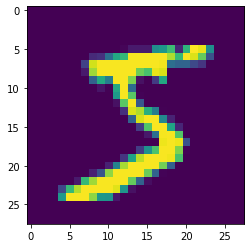

In [8]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]